In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_,distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session =Session(engine)

In [13]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11ddb6210>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [14]:
first_row_2 = session.query(Station).first()
first_row_2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11ddc05d0>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [15]:
for row in session.query(Measurement.date, Measurement.prcp).limit(12).all():
    print(row)

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', None)
('2010-01-07', 0.06)
('2010-01-08', 0.0)
('2010-01-09', 0.0)
('2010-01-10', 0.0)
('2010-01-11', 0.01)
('2010-01-12', 0.0)
('2010-01-14', 0.0)


In [16]:
query = session.query(Measurement.date,Measurement.prcp).group_by(Measurement.date)
df = pd.read_sql_query(query.statement, session.get_bind())
df.head()

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-05,0.00


In [17]:
query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23')
df = pd.read_sql_query(query.statement, session.get_bind())
df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


# Exploratory Climate Analysis

2016-08-23
2017-08-23


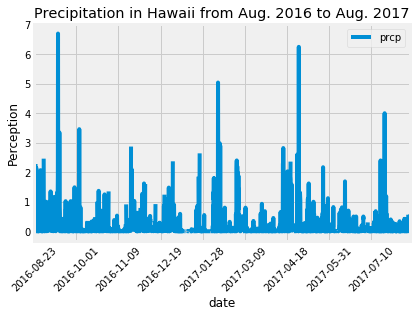

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23',Measurement.date <= '2017-08-23')
df = pd.read_sql_query(query.statement, session.get_bind())
df.head()

# Calculate the date 1 year ago from the last data point in the database
min=df['date'].min()
max=df['date'].max()
print(min)
print(max)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23')

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(query.statement, session.get_bind())
df.head()

# Sort the dataframe by date
df.set_index('date', inplace=True)
df=df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
bar= df.plot(rot=45)
bar.set_title('Precipitation in Hawaii from Aug. 2016 to Aug. 2017')
bar.set_ylabel('Perception')
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(func.count(distinct(Measurement.station))).all()

station_query

[(9)]

In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts =  session.query(Measurement.id, Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_counts

pd.DataFrame(station_counts,
             columns=["ID","Station","Count"]
            ).sort_values("Count",ascending=False)

,ID,Station,Count
0,12188,USC00519281,2772
1,1,USC00519397,2724
2,2725,USC00513117,2709
3,9519,USC00519523,2669
4,16939,USC00516128,2612
5,5434,USC00514830,2202
6,14960,USC00511918,1979
7,7636,USC00517948,1372
8,9008,USC00518838,511


In [56]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                    filter(Measurement.station == 'USC00519281').all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [58]:
temp_counts

[(12188, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2725, 'USC00513117', 2709),
 (9519, 'USC00519523', 2669),
 (16939, 'USC00516128', 2612),
 (5434, 'USC00514830', 2202),
 (14960, 'USC00511918', 1979),
 (7636, 'USC00517948', 1372),
 (9008, 'USC00518838', 511)]

In [57]:
temp_counts =  session.query(Measurement.id, Measurement.station, func.count(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
temp_counts

pd.DataFrame(station_counts,
             columns=["ID","Station","Count"]
            ).sort_values("Count",ascending=False)


,ID,Station,Count
0,12188,USC00519281,2772
1,1,USC00519397,2724
2,2725,USC00513117,2709
3,9519,USC00519523,2669
4,16939,USC00516128,2612
5,5434,USC00514830,2202
6,14960,USC00511918,1979
7,7636,USC00517948,1372
8,9008,USC00518838,511


In [61]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_hist =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date >= '2016-08-23').all()
temp_hist

temp_df = pd.DataFrame(temp_hist,
             columns=["Date","Temp"]
            )
temp_df.head()

,Date,Temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


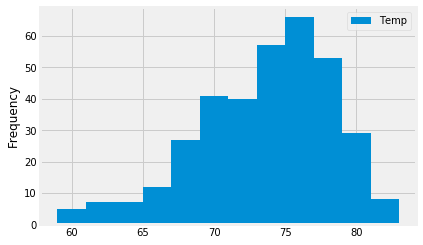

In [65]:

temp_df.plot(kind="hist",bins=12);

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
